# MediaPipeを使ってみる
本レポートではGoogle社が提供している[MediaPipe](https://developers.google.com/mediapipe)を使用し，自然言語処理，画像処理におけるAI技術を実際に動かしてみる．\
図1. MediaPipeのイメージ図
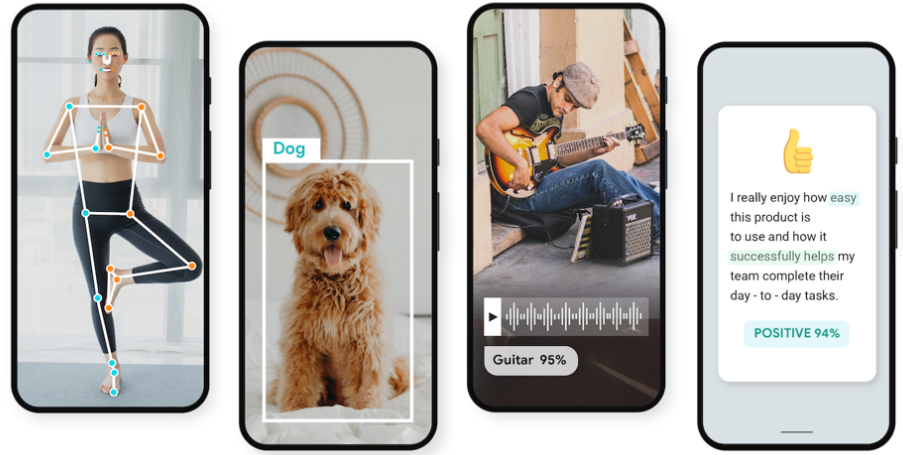

## 動作環境
Google Colaboratoryを使用し，動作させたものをpdf化している．

In [ ]:
# Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive/')

# 目的の場所（フォルダ・ディレクトリ）へ移動
%cd "/content/drive/MyDrive/images"

## 1. やったこと・動かしたものの概要
MediaPipeに用意されているものの一部である自然言語処理と画像処理を動かしてみる．MediaPipeにはローコードで動かせるAPIが用意されているため，それを用いて行う．
###自然言語処理
Text Classfication, Language Detectionの2種類を動かしてみる．
###画像処理
Image Classification, Object Detectionの2種類について動かしてみる．


In [ ]:
# MediaPipeのインストール
!pip install -q mediapipe

## 2. 具体的な手続き
実際にコードを動かしながら， 自然言語と画像の二つの処理を行う．
### 2.1. 自然言語処理
Text ClassificationとLanguage Detectionの2種について実装する．
#### Text Classification
Text Classificationはテキストの内容を分析して特定のカテゴリーやクラスに自動的に分類する技術である．用意されているモデルは`positive`か`negative`を判断するものであり， [SST-2](https://nlp.stanford.edu/sentiment/index.html) (Stanford Sentiment Treebank) という英語の映画レビューのデータセットで学習している．

今回は，英語で`positive`なレビューとして
```
"Absolutely breathtaking! The cinematography in this film is stunning, capturing the essence of the narrative beautifully.
The lead performances are compelling and deeply emotive, making it an unforgettable cinematic experience.
A must-see for anyone who appreciates masterful storytelling and visual artistry. "
```

日本語にしたもの
```
"本当に息をのむ美しさです！この映画の撮影は素晴らしく、物語の本質を見事に捉えています。
主演の演技は引き込まれるもので、非常に感動的で、忘れられない映画体験となりました。
優れたストーリーテリングと視覚芸術を評価する人には必見です。"
```
英語で`negative`なレビューとして
```
"Disappointingly underwhelming.
The plot was predictable and lacked originality, dragging on without much excitement or depth.
The performances were mediocre at best, failing to evoke any real emotion.
Overall, it was a forgettable film that I wouldn't recommend wasting time on."
```
日本語にしたもの
```
"期待はずれで残念です。
プロットは予測可能で独創性に欠け、深みや興奮もなくだらだらと続きました。
演技もせいぜい平凡で、本当の感情を引き出すことには失敗しました。
全体的に忘れられる映画で、時間を無駄にすることはお勧めしません。"
```
の4つの文をモデルに入力する． (レビュー文はChatGPT4で生成したもの)

In [ ]:
# モデルのインストール
!wget -O classifier.tflite -q https://storage.googleapis.com/mediapipe-models/text_classifier/bert_classifier/float32/1/bert_classifier.tflite

In [ ]:
# 入力文の定義
INPUT_POSITIVE_EN = "Absolutely breathtaking! The cinematography in this film is stunning, capturing the essence of the narrative beautifully. \
                        The lead performances are compelling and deeply emotive, making it an unforgettable cinematic experience. \
                        A must-see for anyone who appreciates masterful storytelling and visual artistry. "
INPUT_POSITIVE_JA = "本当に息をのむ美しさです！この映画の撮影は素晴らしく、物語の本質を見事に捉えています。\
                        主演の演技は引き込まれるもので、非常に感動的で、忘れられない映画体験となりました。\
                        優れたストーリーテリングと視覚芸術を評価する人には必見です。"
INPUT_NEGATIVE_EN = "Disappointingly underwhelming. \
                        The plot was predictable and lacked originality, dragging on without much excitement or depth. \
                        The performances were mediocre at best, failing to evoke any real emotion. \
                        Overall, it was a forgettable film that I wouldn't recommend wasting time on."
INPUT_NEGATIVE_JA = "期待はずれで残念です。\
                        プロットは予測可能で独創性に欠け、深みや興奮もなくだらだらと続きました。\
                        演技もせいぜい平凡で、本当の感情を引き出すことには失敗しました。\
                        全体的に忘れられる映画で、時間を無駄にすることはお勧めしません。"

In [ ]:
# 実装
from mediapipe.tasks import python
from mediapipe.tasks.python import text

# 分類器の定義
base_options = python.BaseOptions(model_asset_path="classifier.tflite")
options = text.TextClassifierOptions(base_options=base_options)
classifier = text.TextClassifier.create_from_options(options)

In [ ]:
# テキストの分類
result_pos_en = classifier.classify(INPUT_POSITIVE_EN)
result_pos_ja = classifier.classify(INPUT_POSITIVE_JA)
result_neg_en = classifier.classify(INPUT_NEGATIVE_EN)
result_neg_ja = classifier.classify(INPUT_NEGATIVE_JA)

In [ ]:
# 分類結果の出力
top_pos_en = result_pos_en.classifications[0].categories[0]
top_pos_ja = result_pos_ja.classifications[0].categories[0]
top_neg_en = result_neg_en.classifications[0].categories[0]
top_neg_ja = result_neg_ja.classifications[0].categories[0]

print(f"English Positive review: {top_pos_en.category_name} ({top_pos_en.score:.2f})")
print(f"Japanese Positive review: {top_pos_ja.category_name} ({top_pos_ja.score:.2f})")
print(f"English Negative review: {top_neg_en.category_name} ({top_neg_en.score:.2f})")
print(f"Japanedese Negative review: {top_neg_ja.category_name} ({top_neg_ja.score:.2f})")

English Positive review: positive (1.00)
Japanese Positive review: negative (0.83)
English Negative review: negative (1.00)
Japanedese Negative review: negative (0.94)


英語のレビューについては予測確率100%で推論しているのに対し，日本語レビューは予測値が低く出ていることがわかった．さらに日本語の`Positive`なレビューについては`Negative`と推論されており，正しく推論できていないことがわかる．英語のみで事前学習しているため，日本語での性能はとても低くなることがわかった．

### Language Recognition
Language Recognitonは文章がどの言語で書かれているかを推論するものである．MediaPipeで用意されているものでは110の言語を分類することができ，分類ラベルは[label](https://storage.googleapis.com/mediapipe-tasks/language_detector/labels.txt)となっている．

分類は先ほどの英語と日本語の`Positive`な文を用いる．また日本語と英語が混ざった文章として，
```
"ひび割れた幸せな時を過ごすほど, I'm sick of it. 飢えている悲しいハイエナみたいだ．"
```
[ハイエナ](https://www.kkbox.com/jp/ja/song/TY-6hnn1GziN4YTPWS) (My First Story)より

も推論させてみる．

In [ ]:
# モデルのインストール
!wget -O detector.tflite -q \
https://storage.googleapis.com/mediapipe-models/language_detector/language_detector/float32/latest/language_detector.tflite

In [ ]:
# 実装
INPUT_EN_JA = "ひび割れた幸せな時を過ごすほど, I'm sick of it. 飢えている悲しいハイエナみたいだ．"

# 分類器の定義
base_options = python.BaseOptions(model_asset_path="detector.tflite")
options = text.LanguageDetectorOptions(base_options=base_options)
detector = text.LanguageDetector.create_from_options(options)

In [ ]:
# 分類
detection_pos_en = detector.detect(INPUT_POSITIVE_EN)
detection_pos_ja = detector.detect(INPUT_POSITIVE_JA)
detection_ja_en = detector.detect(INPUT_EN_JA)

In [ ]:
# 分類結果
for detection in detection_pos_en.detections:
  print(f"English Positive review: {detection.language_code} ({detection.probability:.2f})")
for detection in detection_pos_ja.detections:
  print(f"Japanese Positive review: {detection.language_code} ({detection.probability:.2f})")
for detection in detection_ja_en.detections:
  print(f"Mix Music reric: {detection.language_code} ({detection.probability:.2f})")

English Positive review: en (1.00)
Japanese Positive review: ja (1.00)
Mix Music reric: ja (1.00)


英語と日本語の映画レビュー文は正しく`en`, `ja`と分類されていることがわかる．英語と日本語が混ざった文では少し予測確率が下がると予想していたが100%`ja`という結果になった．

### 2.2. 画像処理
画像処理ではImage Classification, Object Detection, Gesture Recognitionの2つについて動かしてみる．
#### Image Classification
Image Classificationでは画像内の物体を分類するタスクである．MediaPipeではGoogle社が投稿した論文にもあるモデル [EfficientNet](https://developers.google.com/mediapipe/solutions/vision/image_classifier#efficientnet-lite2_model)というCNNベースのモデルを使用している．このモデルを[ImageNet](https://www.image-net.org/)で学習させ，1,000クラス分類 [(ラベル)](https://storage.googleapis.com/mediapipe-tasks/image_classifier/labels.txt) ができるものになっている．

**使用モデル** : EfficientNet-lite2 (float32)

In [ ]:
# モデルのインストール
!wget -O classifier.tflite -q https://storage.googleapis.com/mediapipe-models/image_classifier/efficientnet_lite0/float32/1/efficientnet_lite0.tflite

使用する画像はダルメシアンの画像である．具体的な犬種まで分類できるか気になる．

引用： 愛犬ハニー

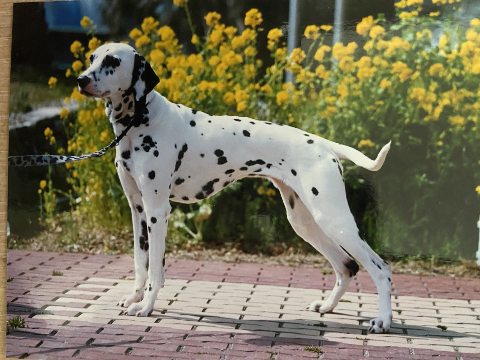

In [ ]:
# 使用画像のロード，表示
import cv2
from google.colab.patches import cv2_imshow
import math

DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)

image = cv2.imread("honey.jpg")
resize_and_show(image)

In [ ]:
import mediapipe as mp
from mediapipe.tasks.python.components import processors
from mediapipe.tasks.python import vision

# 分類器の定義
base_options = python.BaseOptions(model_asset_path='classifier.tflite')
options = vision.ImageClassifierOptions(
    base_options=base_options, max_results=4)
classifier = vision.ImageClassifier.create_from_options(options)

In [ ]:
# 分類
image = mp.Image.create_from_file("honey.jpg")
classification_result = classifier.classify(image)

In [ ]:
# 結果の表示
top_category = classification_result.classifications[0].categories[0]
print(f"{top_category.category_name} ({top_category.score:.2f})")

dalmatian (0.49)


ダルメシアンと推論されたが予測確率が低いことがわかる．影のつき方や，模様などによっても予測に影響が出そうだと考える．
影のつき方や模様のつき方が一般的なダルメシアンで推論させてみる．

引用: https://kc-media-cdn-live.azureedge.net/cache/d/c/f/e/a/6/dcfea63db5a25100264c5a17ce49aa5fe6056614.jpg

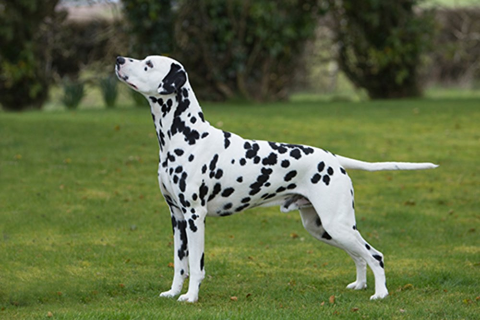

In [ ]:
image = cv2.imread("dalmatian.jpg")
resize_and_show(image)

In [ ]:
# 分類
image = mp.Image.create_from_file("dalmatian.jpg")
classification_result = classifier.classify(image)
# 結果の表示
top_category = classification_result.classifications[0].categories[0]
print(f"{top_category.category_name} ({top_category.score:.2f})")

dalmatian (0.94)


きちんとダルメシアンを推論することができており，「犬」だけではなく犬種まで識別できることがわかった．
モデルの推論予測は画像のスタイルによっても異なることがわかった．

#### Object Detection
Object Detectionは画像内の物体のカテゴリと位置を認識するタスクである．Image Classificationと違いカテゴリだけでなく，物体の位置を四隅の座標点からなるバウンディングボックスを出力する．MediaPipeではImage Classificationと同じようにEfficientNetを用いており，物体検出タスクでよく使われる[COCO Dataset](https://cocodataset.org/)を使用し訓練したモデルが用意されている．

他にもシングルショットで検出できるSSDも用意されているが，時間は考慮しなくて良いため，性能重視のEfficientDet-Lite2 (Detection版EfficientNet)を使用する．

こちらは80classのカテゴリ分類 [(ラベル)](https://storage.googleapis.com/mediapipe-tasks/object_detector/labelmap.txt) が可能になっている．

使用する画像はImage Classificationと同じである．

In [ ]:
# モデルのインストール
!wget -q -O efficientdet.tflite -q https://storage.googleapis.com/mediapipe-models/object_detector/efficientdet_lite0/int8/1/efficientdet_lite0.tflite

In [ ]:
import numpy as np

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


# 可視化関数
def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(image, start_point, end_point, TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return image

# 検出器の定義
base_options = python.BaseOptions(model_asset_path='efficientdet.tflite')
options = vision.ObjectDetectorOptions(base_options=base_options,
                                       score_threshold=0.2)
detector = vision.ObjectDetector.create_from_options(options)

In [ ]:
# 画像の定義
image = mp.Image.create_from_file("honey.jpg")

# 検出
detection_result = detector.detect(image)

# 可視化
image_copy = np.copy(image.numpy_view())
annotated_image = visualize(image_copy, detection_result)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
cv2_imshow(rgb_annotated_image)

Output hidden; open in https://colab.research.google.com to view.

こちらは物体の位置自体は正しく認識することができているが，`dog`ではなく`bird`と認識されてしまった．

In [ ]:
detection_result

DetectionResult(detections=[Detection(bounding_box=BoundingBox(origin_x=190, origin_y=117, width=1054, height=904), categories=[Category(index=None, score=0.6796875, display_name=None, category_name='bird')], keypoints=[])])

検出結果を詳しく見てみると，２番目以降の結果も`dog`とはなっておらず，この画像自体を犬と判断はしていないようである．画像分類と同じようなアーキテクチャを使用しているがこのように違っているため，画像分類でも`dalmatian`と判定しているがそれが犬かどうかまでは認識していないとわかる．

以上の検証から自然言語処理や画像処理におけるタスクであったり，どんな推論結果が返ってくるかを体験することができた．

## 3. わかったこと・わからなかったこと
今回の検証で，事前に用意されたAPIを利用しましたが，モデルがどのような処理を経て結果を推測しているのか具体的な詳細まではわからなかった．特に自然言語処理では，BERTモデルが使われてお，これはTransformerアーキテクチャに基づいていると思われるが，その内部構造については完全には理解できていない．加えて，日本語や英語のテキストを何も前処理せずにモデルに投げても適切に認識されましたが，実際にどのような処理が行われているのかは不明である．この講義を通じて，Transformerベースのアーキテクチャについて深く理解を深めたいと考えている．